In [1]:
import pandas as pd
import numpy as np

In [11]:
mkt = pd.read_csv(r'C:\Users\ffliguer\Desktop\Proyectos\Market projects\Estrategias con riesgo\Estrategias en SP500\backups\backup_sp500_200301_202205.csv')
days = 1

string = 'mkt_diff_' + str(days) + 'd'

mkt[string] = mkt['Close'].shift(-days)/mkt['Close'] - 1
mkt['contexto'] = np.where(mkt[string] < -0.0025, '3 - Bajista', 
                  np.where(mkt[string] < 0.0025, '2 - Lateral', 
                           '1 - Alcista')) # A priori vamos a considerar 25% proba bajista, 50% proba lateral, 25% proba alcista

df = pd.read_csv(r'C:\Users\ffliguer\Desktop\Proyectos\Market projects\Estrategias con riesgo\Estrategias en SP500\backups\backup_564_201501_202204.csv')

string_ticker = 'ticker_diff_' + str(days) + 'd'
df[string_ticker] = np.where(df['Ticker'].shift(-days) == df['Ticker'], df['Close'].shift(-days)/df['Close'] - 1, np.nan)

df = pd.merge(df[['Date', 'Ticker', 'Adj Close', string_ticker]], mkt[['Date', string, 'contexto']], left_on='Date', right_on='Date', how='left').dropna()
df['outperforming'] = np.where(df[string_ticker] > df[string], 1, 0)

print('Promedio general de outperforming:', round(df.outperforming.mean(), 5))
grouped_base_analisis = df.groupby('contexto')

grouped_base_analisis.agg({
    'outperforming': ['count', 'mean'],
    string: ['mean', 'median', 'std'],
    'Ticker': 'nunique'
})

Promedio general de outperforming: 0.50079


outperforming           mkt_diff_1d                      Ticker
                    count      mean        mean    median       std nunique
contexto                                                                   
1 - Alcista        379281  0.482885    0.009581  0.007652  0.008523     564
2 - Lateral        330649  0.506573    0.000034 -0.000007  0.001382     564
3 - Bajista        294644  0.517363   -0.010852 -0.007421  0.010805     564

La distribución es relativamente pareja: hay outperformings en los tres contextos.

In [12]:
import pandas as pd

def calculate_rsi(data, window):
    returns = data.pct_change()
    up = returns.clip(lower=0)  # levanta los valores que fueron superiores al valor indicado = 0
    down = returns.clip(upper=0)
    ema_up = up.ewm(com=window, adjust=False).mean()
    ema_down = down.ewm(com=window, adjust=False).mean()
    rs = -(ema_up / ema_down)
    datarsi = 100 - (100 / (1 + rs))
    rsi = round(datarsi, 2)
    return rsi

def calculate_macd(data, window_short, window_long):
    emashort = data.ewm(span=window_short, adjust=False).mean()
    emalong = data.ewm(span=window_long, adjust=False).mean()
    macd = emashort - emalong
    return macd

df_rsi = df.groupby('Ticker')['Adj Close'].apply(lambda x: calculate_rsi(x, 14))
df_rsi = df_rsi.reset_index().rename(columns={'Adj Close': 'RSI'})

In [4]:
# Para generar variable de outperfomed

# import pandas as pd
# df = df.sort_values('Date', ascending=True)
# partitions = df.groupby(['Ticker', 'contexto'])
# df['mean_outperfomed'] = partitions['outperforming'].rolling(20, min_periods=20).mean().reset_index(drop=True) * 100

### Un único modelo sobre el RSI

In [13]:
pd.merge(df, df_rsi, left_index=True, right_on='index')

,Date,Ticker,Adj Close,ticker_diff_1d,mkt_diff_1d,contexto,outperforming,index,RSI
0,2015-01-02,AAL,51.079922,-0.000556,-0.018278,3 - Bajista,1,0,NaN
1,2015-01-05,AAL,51.051487,-0.015590,-0.008893,3 - Bajista,0,1,0.00
2,2015-01-06,AAL,50.255589,-0.000566,0.011630,1 - Alcista,0,2,0.00
3,2015-01-07,AAL,50.227158,0.012262,0.017888,1 - Alcista,0,3,0.00
4,2015-01-08,AAL,50.843029,-0.030563,-0.008404,3 - Bajista,0,4,36.98
...,...,...,...,...,...,...,...,...,...
1004569,2022-04-22,ES,91.348251,-0.014239,0.005698,1 - Alcista,0,1005134,61.46
1004570,2022-04-25,ES,90.047539,-0.010696,-0.028146,3 - Bajista,1,1005135,55.00
1004571,2022-04-26,ES,89.084404,-0.002341,0.002098,2 - Lateral,0,1005136,50.71
1004572,2022-04-27,ES,88.875893,0.007709,0.024747,1 - Alcista,0,1005137,49.80


In [15]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

base = pd.merge(df, df_rsi, left_index=True, right_on='index').dropna()[['Date', 'Ticker', 'contexto', 'RSI', 'outperforming']].reset_index(drop=True)
base.columns = ['Date', 'Ticker', 'Contexto', 'RSI', 'Outperforming']

X = base[['RSI']]
y = base['Outperforming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar el modelo de regresión logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Obtener el coeficiente de RSI
coef_rsi = logreg.coef_[0][0]
print('Coeficiente de RSI:', round(coef_rsi, 5))

# Predecir los valores de 'outperforming' en el conjunto de prueba
y_pred = logreg.predict(X_test)

# Calcular la precisión del modelo en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy del modelo: {:.2f}'.format(accuracy))

# Calcular la matriz de confusión en el conjunto de prueba
confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(confusion)

Coeficiente de RSI: -0.00076
Accuracy del modelo: 0.50
Matriz de confusión:
[[34756 65689]
 [34243 66107]]


In [16]:
df_multimodel = pd.DataFrame()

for context in np.sort(base.Contexto.unique()):
    print('Modelo para el contexto', context)
    X = base[base.Contexto == context][['RSI']]
    y = base[base.Contexto == context]['Outperforming']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y ajustar el modelo de regresión logística
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    # Obtener el coeficiente de RSI
    coef_rsi = logreg.coef_[0][0]
    print('Coeficiente de RSI:', round(coef_rsi, 5))

    # Predecir los valores de 'outperforming' en el conjunto de prueba
    y_pred = logreg.predict(X_test)
    df_model = pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred})
    df_multimodel = df_multimodel.append(df_model, ignore_index=True)

print('Multimodel:')    
# Calcular la precisión del modelo en el conjunto de prueba
accuracy = accuracy_score(df_multimodel['y_test'], df_multimodel['y_pred'])
print('Precisión del modelo: {:.2f}'.format(accuracy))

# Calcular la matriz de confusión en el conjunto de prueba
confusion = confusion_matrix(df_multimodel['y_test'], df_multimodel['y_pred'])
print('Matriz de confusión:')
print(confusion)

Modelo para el contexto 1 - Alcista
Coeficiente de RSI: -0.00787
Modelo para el contexto 2 - Lateral
Coeficiente de RSI: 0.00043
Modelo para el contexto 3 - Bajista
Coeficiente de RSI: 0.00641
Multimodel:
Precisión del modelo: 0.52
Matriz de confusión:
[[36354 63842]
 [33448 67151]]


### Bootstrap

<AxesSubplot:xlabel='Variable', ylabel='Coeficiente'>

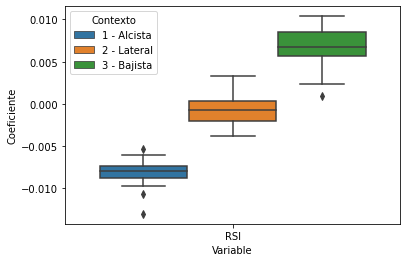

In [17]:
import random
import seaborn as sns

bootstrap_coefficients = pd.DataFrame(columns=['Contexto', 'Variable', 'Coeficiente'])

n = 20
i = 0
while i < n:
    set_tickers = random.sample(list(base.Ticker.unique()), n)
    for context in np.sort(base.Contexto.unique()):
        X = base[(base.Ticker.isin(set_tickers))&(base.Contexto == context)][['RSI']]
        y = base[(base.Ticker.isin(set_tickers))&(base.Contexto == context)]['Outperforming']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)

        coef_rsi = logreg.coef_[0][0]
        bootstrap_coefficients = bootstrap_coefficients.append({'Contexto': context, 'Variable':'RSI', 'Coeficiente': coef_rsi}, ignore_index=True)
    i = i + 1

sns.boxplot(x = bootstrap_coefficients['Variable'],
            y = bootstrap_coefficients['Coeficiente'],
            hue = bootstrap_coefficients['Contexto'])
